In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

root = '/content/drive/My Drive/2024 Spring/6.8301/CV_Final_Project/'
# root = '/content/drive/My Drive/CV_Final_Project/'

#Training the model

In [ ]:
class SkinLesionDataset(Dataset):
    #csv_file = truth.csv, root_dir = isic_dataset path
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Filter malignant and benign samples
        self.malignant_data = self.data[self.data['target'] == 1]
        self.benign_data = self.data[self.data['target'] == 0]

        # Compute sample sizes for malignant and benign data
        num_malignant_samples = len(self.malignant_data)
        num_benign_samples = len(self.benign_data)

        # Shuffle the sampled data
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name_without_extension = self.data.iloc[idx, self.data.columns.get_loc("image_name")]
        img_name_with_extension = "augmented_" + img_name_without_extension + ".jpg"
        img_path = os.path.join(self.root_dir, 'train_augmented', img_name_with_extension)
        if not os.path.exists(img_path):
            print(f"Image file '{img_path}' not found.")
            return None
        image = Image.open(img_path)
        label = self.data.iloc[idx, self.data.columns.get_loc("target")]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_training_counts(self):
        malignant = self.data[self.data['target'] == 1]
        benign = self.data[self.data['target'] == 0]
        return len(malignant), len(benign), len(self.data)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = SkinLesionDataset(csv_file='/content/drive/My Drive/2024 Spring/6.8301/CV_Final_Project/training_dataset.csv', root_dir='/content/drive/My Drive/2024 Spring/6.8301/CV_Final_Project/isic_dataset/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
malignant, benign, training = dataset.get_training_counts()
print("Number of malignant tumors in training dataset:", malignant)
print("Number of benign tumors in training dataset:", benign)
print("Number of tumors in training dataset:", training)

print(len(dataset))

Number of malignant tumors in training dataset: 462
Number of benign tumors in training dataset: 862
Number of tumors in training dataset: 1324
1324


In [ ]:
#Load model 2.0
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Replace fc layer with new one for 2 classes

# Load the state dictionary
state_dict = torch.load('/content/drive/My Drive/2024 Spring/6.8301/CV_Final_Project/checkpoints/model_2.0.pth')

# Load the state dictionary into the model (ensure 'strict=False' to ignore size mismatches)
model.load_state_dict(state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.3MB/s]


<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#train model
num_epochs = 3
running_loss = 0.0
for epoch in range(num_epochs):
    for batch_idx, (images, label) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 10 == 9:    # Print every 10 mini-batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

Epoch [1/3], Batch [10/42], Loss: 0.0387
Epoch [1/3], Batch [20/42], Loss: 0.0422
Epoch [1/3], Batch [30/42], Loss: 0.0393
Epoch [1/3], Batch [40/42], Loss: 0.0321
Epoch [2/3], Batch [10/42], Loss: 0.0310
Epoch [2/3], Batch [20/42], Loss: 0.0217
Epoch [2/3], Batch [30/42], Loss: 0.0174
Epoch [2/3], Batch [40/42], Loss: 0.0201
Epoch [3/3], Batch [10/42], Loss: 0.0117
Epoch [3/3], Batch [20/42], Loss: 0.0083
Epoch [3/3], Batch [30/42], Loss: 0.0077
Epoch [3/3], Batch [40/42], Loss: 0.0083


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/2024 Spring/6.8301/CV_Final_Project/checkpoints/model_3.0.pth')

#Testing the model

In [90]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Replace fc layer with new one for 2 classes

# Load the state dictionary
state_dict = torch.load(root + 'checkpoints/model_3.0.pth')

# Load the state dictionary into the model (ensure 'strict=False' to ignore size mismatches)
model.load_state_dict(state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [100]:
class TestDataset(Dataset):
    #data = dataset.test
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name_without_extension = self.data.iloc[idx, self.data.columns.get_loc("image_name")]
        img_name_with_extension = img_name_without_extension + ".jpg"
        img_path = os.path.join(self.root_dir, 'train', img_name_with_extension)
        if not os.path.exists(img_path):
            print(f"Image file '{img_path}' not found.")
            return None
        image = Image.open(img_path)
        label = self.data.iloc[idx, self.data.columns.get_loc("target")]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_test_counts(self):
        malignant = self.data[self.data['target'] == 1]
        benign = self.data[self.data['target'] == 0]
        return len(malignant), len(benign), len(self.data)

In [101]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [102]:
#load test dataset
test = TestDataset(data=pd.read_csv(root + 'testing_dataset.csv'), root_dir=root + 'isic_dataset/', transform = transform)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

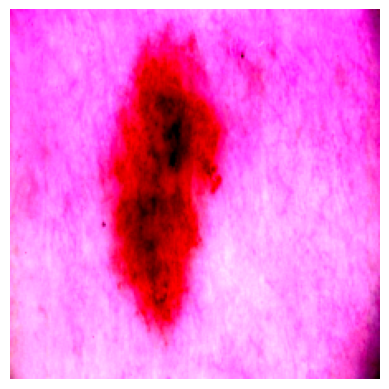

In [104]:
# Get an image from the dataset
for image, labels in test_loader:
    image = images[1]  # Take the first image from the batch
    break

# Visualize the transformed image
image = image.permute(1, 2, 0)  # Change the tensor shape from CxHxW to HxWxC for visualization
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
malignant, benign, test = test.get_test_counts()
print("Number of malignant tumors in test dataset:", malignant)
print("Number of benign tumors in test dataset:", benign)
print("Number of tumors in test dataset:", test)

Number of malignant tumors in test dataset: 122
Number of benign tumors in test dataset: 210
Number of tumors in test dataset: 332


##Accuracy Score

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth labels
predictions = []
ground_truth = []
probability = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        output = model(images)
        probabilities = F.softmax(output, dim=1)
        predicted = (probabilities[:, 1] > 0.5).int()
        print(predicted)

        # Append predictions and ground truth labels
        probability.extend(probabilities[:, 1].tolist())
        predictions.extend(predicted.tolist())
        ground_truth.extend(labels.tolist())

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1], dtype=torch.int32)
tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0], dtype=torch.int32)
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 0], dtype=torch.int32)
tensor([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1], dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0], dtype=torch.int32)
tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1], dtype=torch.int32)
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
print(probability)
print(predictions)
print(ground_truth)

[0.8844138383865356, 0.0029206962790340185, 0.4747675657272339, 0.0289299376308918, 0.00199992791749537, 0.13467498123645782, 0.06509683281183243, 0.06304081529378891, 0.05617867037653923, 0.0004117911448702216, 0.313722163438797, 0.1871616691350937, 0.0022880786564201117, 0.0012533057015389204, 0.0032876452896744013, 0.02526251971721649, 0.527571439743042, 0.0018423129804432392, 0.0040028817020356655, 0.001411006087437272, 0.9357596635818481, 0.47469472885131836, 0.061402615159749985, 0.003170989453792572, 0.32182976603507996, 0.9736598134040833, 9.191225399263203e-05, 0.38249751925468445, 0.987360954284668, 0.9612563252449036, 0.9888353943824768, 0.8581864833831787, 0.9329054951667786, 0.0005161194712854922, 0.9978914856910706, 0.9160088896751404, 0.007039891555905342, 0.8003164529800415, 0.008798686787486076, 0.8740372061729431, 0.26447296142578125, 0.20522333681583405, 0.8811317086219788, 0.0003399754350539297, 0.9292940497398376, 0.02072092890739441, 0.006753549911081791, 0.126377

In [ ]:
correct = 0
total = len(predictions)
for i in range(total):
  if predictions[i] == ground_truth[i]:
    correct += 1

print(correct/total)

0.8192771084337349


##Confusion Matrix

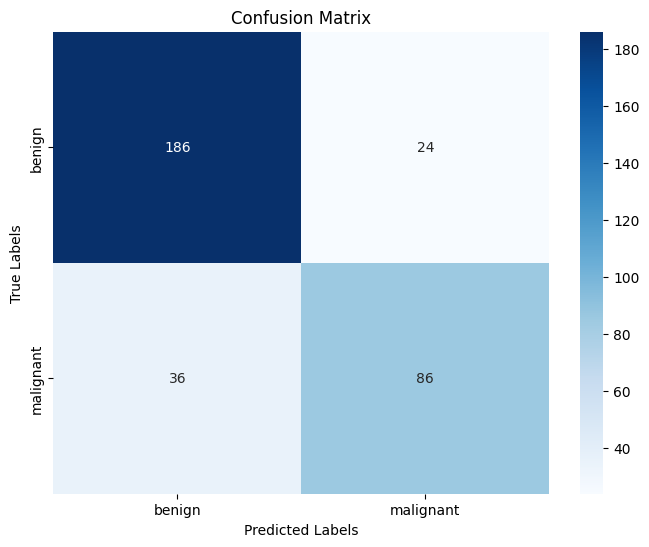

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert lists to numpy arrays
predicted = np.array(predictions)
truth = np.array(ground_truth)
probabilities = np.array(probability)

# Create confusion matrix
conf_matrix = confusion_matrix(truth, predicted)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
class_labels = ['benign', 'malignant']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Set custom tick labels for x-axis and y-axis
plt.xticks(ticks=[0.5, 1.5], labels=class_labels, ha='center')
plt.yticks(ticks=[0.5, 1.5], labels=class_labels, va='center')

plt.show()

##Precision Recall Curve (kind of broken ngl)

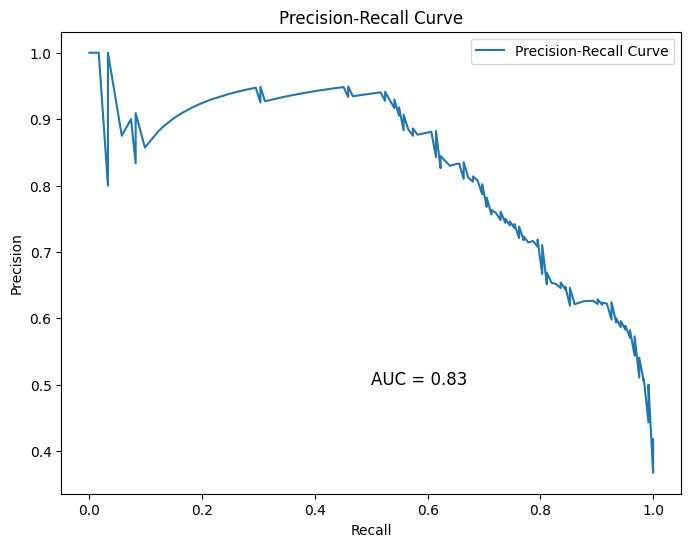

In [ ]:
precision_list = []
recall_list = []
thresholds = np.linspace(0, 1, 1000)

for threshold in thresholds:
    predictions = (probabilities > threshold).astype(int)

    TP = np.sum((predictions == 1) & (truth == 1))
    FP = np.sum((predictions == 1) & (truth != 1))
    TN = np.sum((predictions != 1) & (truth != 1))
    FN = np.sum((predictions != 1) & (truth == 1))

    precision = TP / (TP + FP) if (TP + FP) != 0 else 1
    recall = TP / (TP + FN)

    precision_list.append(precision)
    recall_list.append(recall)

precision_recall_sorted = sorted(zip(recall_list, precision_list), key=lambda x: x[0])
recall_list_sorted, precision_list_sorted = zip(*precision_recall_sorted)

plt.figure(figsize=(8, 6))
plt.plot(recall_list_sorted, precision_list_sorted, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

auc = np.trapz(precision_list_sorted, recall_list_sorted)
plt.text(0.5, 0.5, f'AUC = {auc:.2f}', fontsize=12)
plt.show()

##Grad-CAM Visualization

In [ ]:
!pip install grad-cam

import random
from collections import defaultdict

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


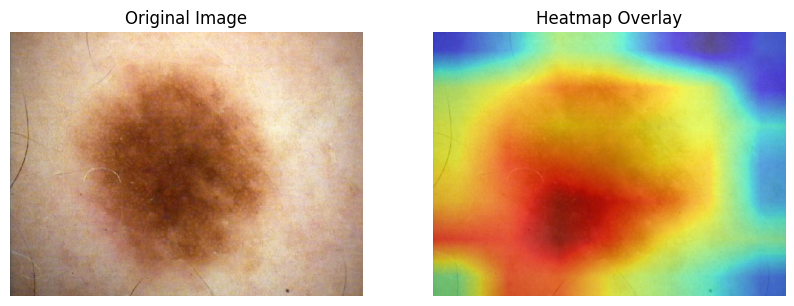

In [ ]:
import cv2

# Define the hook to capture gradients
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradient = None

        # Register the hook
        self.hook = self.model.layer4[-1].register_backward_hook(self.capture_gradients)

    def capture_gradients(self, module, input, output):
        self.feature_maps = input[0].detach()
        self.gradient = output[0].detach()

    def __call__(self, x, target_class=None):
        self.model.zero_grad()
        output = self.model(x)

        if target_class is None:
            target_class = torch.argmax(output)

        output[:, target_class].backward()

        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        grad_cam = nn.functional.relu(grad_cam)

        return grad_cam

# Load an image and preprocess it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(root + 'isic_dataset/train/ISIC_1834920.jpg')
image_tensor = transform(image).unsqueeze(0)

# Get the height and width of the image
original_image_width, original_image_height = image.size

# Compute Grad-CAM
grad_cam = GradCAM(model)
heatmap = grad_cam(image_tensor)

# Convert heatmap to numpy array
heatmap_np = heatmap.squeeze().cpu().numpy()
heatmap_np = np.maximum(heatmap_np, 0)  # ReLU activation

# Normalize the heatmap
heatmap_np /= np.max(heatmap_np)

# Resize heatmap array to match original image dimensions
resized_heatmap = cv2.resize(heatmap_np, (original_image_width, original_image_height))

# Plot original image and heatmap side by side
plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Plot heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(resized_heatmap, alpha=0.6, cmap='jet', interpolation='bicubic')  # Adjust interpolation here
plt.title('Heatmap Overlay')
plt.axis('off')

plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


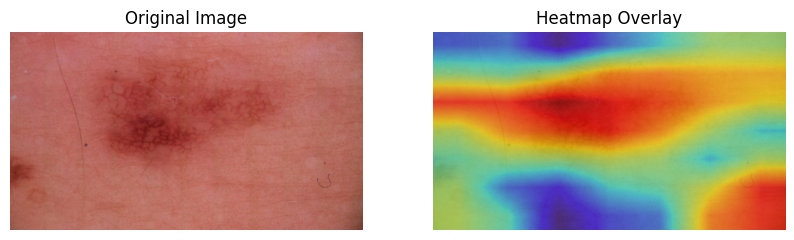

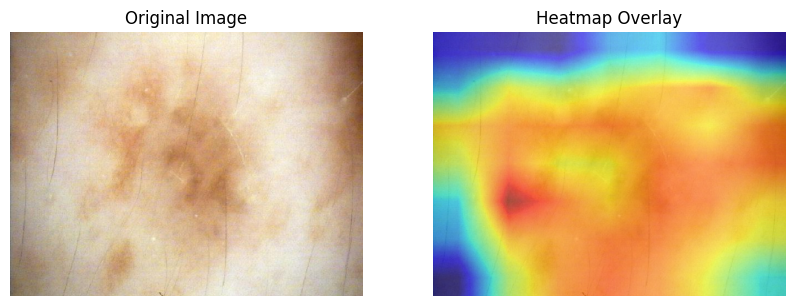

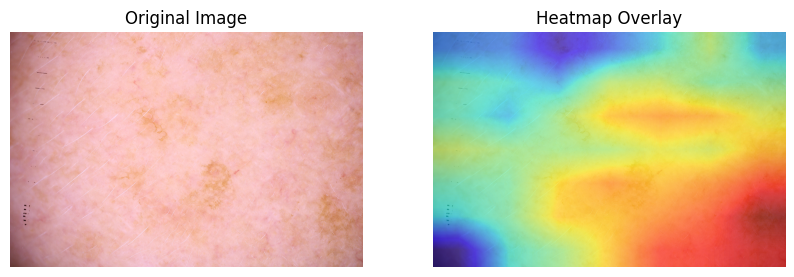

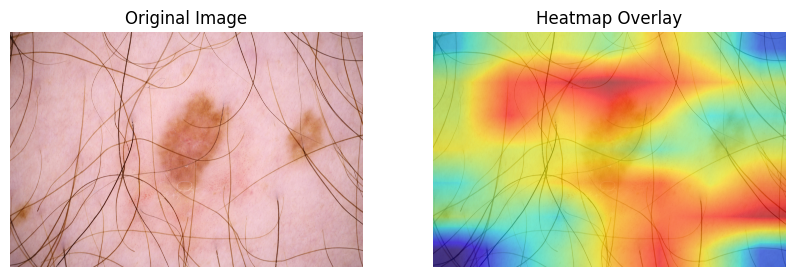

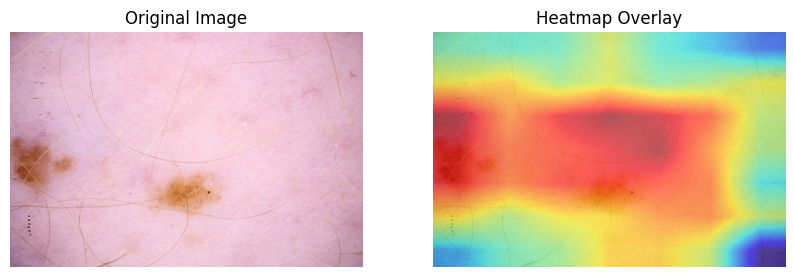

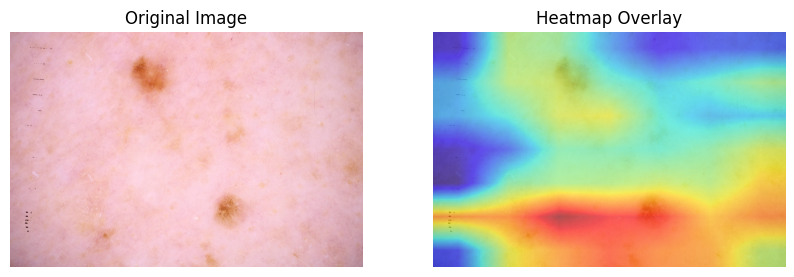

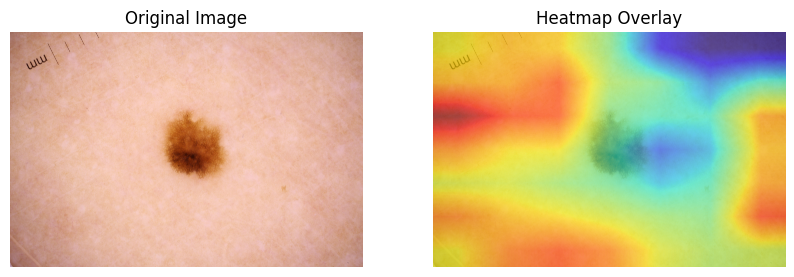

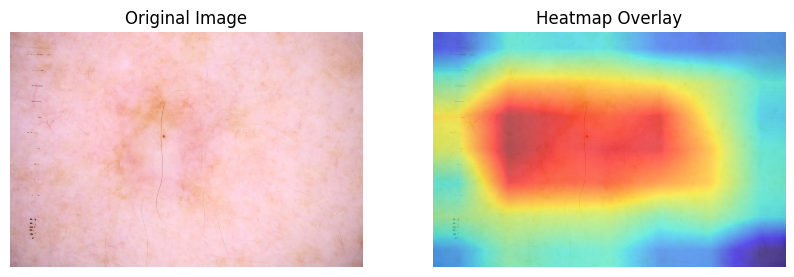

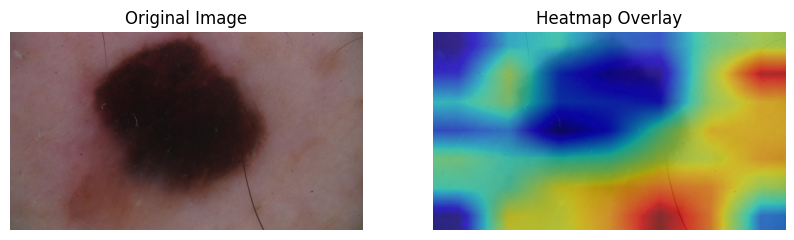

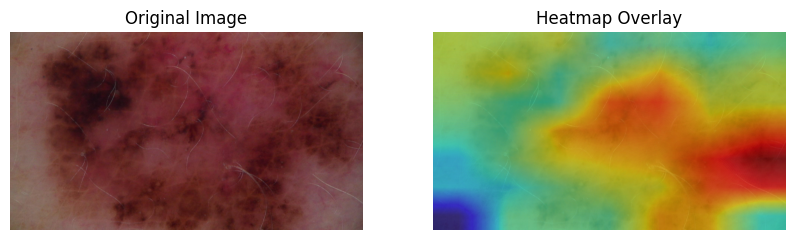

In [ ]:
# Read the testing dataset CSV file
testing_dataset = pd.read_csv(root + 'testing_dataset.csv')

# Extract 10 image paths from the 'image_name' column
image_paths = testing_dataset['image_name'].sample(10)

# Iterate over the selected image paths
for image_path in image_paths:
    # Construct the full path to the image file
    full_image_path = root + 'isic_dataset/train/' + image_path  + '.jpg'
    # Load an image and preprocess it
    image = Image.open(full_image_path)
    image_tensor = transform(image).unsqueeze(0)

    # Compute Grad-CAM
    grad_cam = GradCAM(model)
    heatmap = grad_cam(image_tensor)

    # Convert heatmap to numpy array
    heatmap_np = heatmap.squeeze().cpu().numpy()
    heatmap_np = np.maximum(heatmap_np, 0)  # ReLU activation

    # Normalize the heatmap
    heatmap_np /= np.max(heatmap_np)

    # Resize heatmap array to match original image dimensions
    original_image_width, original_image_height = image.size
    resized_heatmap = cv2.resize(heatmap_np, (original_image_width, original_image_height))

    # Plot original image and heatmap side by side
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(resized_heatmap, alpha=0.6, cmap='jet', interpolation='bilinear')  # Adjust interpolation here
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
